In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install scipy

## Importing require dependencies and starting a spark context.

In [3]:
from pyspark import SparkContext
sc = SparkContext(pyFiles=['lib/numpy_pack.py','lib/row_parser.py','lib/spark_PCA.py'])

from pyspark.sql import Row, SQLContext,DataFrame
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

%pylab inline

#!pip install pandas
#!pip install scipy

import pandas as pd
import datetime as dt

from scipy.io import loadmat,savemat,whosmat

from string import split
from collections import Counter
import re
import numpy as np
from numpy import shape

from glob import glob
from time import time

Populating the interactive namespace from numpy and matplotlib


## Loading the Dataset and Parsing the Rows

In [4]:
import sys
sys.path.append('lib')
from row_parser import *

Parse_rules,field_names,RowObject = init_parser_parameters()

from pyspark.sql import DataFrame

CVS_Data=sc.textFile("/CVS/*/")


def parse(row):
    items=row.split(',')
    D=[]
    for pr in Parse_rules:
        start=pr['start']
        end=pr['end']
        parser=pr['parser']
        if end-start==1:
            D.append(parser(items[start]))
        else:
            D.append(parser(items[start:end]))
    return RowObject(*D)


RDD=CVS_Data.map(parse)

df=sqlContext.createDataFrame(RDD)

('time', 'datetime') {'start': 0, 'parser': <function parse_date at 0x7fc72dd8a668>, 'end': 1, 'name': 'time'}
('species', 'str') {'start': 1, 'parser': <function parse_string at 0x7fc72dd8a848>, 'end': 2, 'name': 'species'}
('site', 'str') {'start': 2, 'parser': <function parse_string at 0x7fc72dd8a848>, 'end': 3, 'name': 'site'}
('rec_no', 'str') {'start': 3, 'parser': <function parse_string at 0x7fc72dd8a848>, 'end': 4, 'name': 'rec_no'}
('bout_i', 'int') {'start': 4, 'parser': <function parse_int at 0x7fc72dd8a758>, 'end': 5, 'name': 'bout_i'}
('peak2peak', 'float') {'start': 5, 'parser': <function parse_float at 0x7fc72dd8a7d0>, 'end': 6, 'name': 'peak2peak'}
('MSN', 'array', 202) {'start': 6, 'parser': <function parse_array at 0x7fc72dd8a6e0>, 'end': 208, 'name': 'MSN'}
('MSP', 'array', 101) {'start': 208, 'parser': <function parse_array at 0x7fc72dd8a6e0>, 'end': 309, 'name': 'MSP'}
('TPWS1', 'bool') {'start': 309, 'parser': <function parse_int at 0x7fc72dd8a758>, 'end': 310, 'n

In [5]:
## Caching the Dataframe
df = df.filter(df.TPWS2==1).filter(df.MD2==0).filter(df.FD2==0)
df.cache().count()

4144531

## Functions to Read MSP

In [6]:
from spark_PCA import *
from row_parser import unpackArray

def trimmed_spectra(row):
    return unpackArray(row.MSP,data_type=numpy.float64)[12:85]

def unpackArray(x,data_type=numpy.int16):
    return np.frombuffer(x,dtype=data_type)

## Eigen Vector Extraction

shape of E= (73,) shape of NE= (73,)


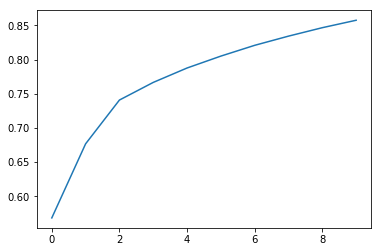

In [7]:
## Get Spectra
spectra=df.rdd.map(trimmed_spectra)

## Extract Eigen Vectors
COV=computeCov(spectra)
eigval,eigvec=LA.eig(COV['Cov'])
eigval=eigval/sum(eigval)

## Check the Reconstruction
plot(cumsum(eigval[:10]))

In [8]:
## Using First 5 Eigen Vectors
V=eigvec[:,0:5]

## Defining a function to return Projection
def project(array):
    return np.dot(array, V)

## Interclick Interval

Writing a UDF to get timestamp with higher precision to calculate Interclick Interval

In [9]:
from pyspark.sql.window import Window
from pyspark.sql.functions import udf, lag, collect_list, col
from pyspark.sql.types import DoubleType

def unix_ts(x):
    from datetime import datetime
    y = datetime.utcfromtimestamp(0)
    return (x-y).total_seconds()

unix_ts_udf = udf(unix_ts, DoubleType())

Calculating ICI for a given window of bout by sorting them by unix_ts

In [10]:
df_with_unix_ts = df.withColumn("unix_ts", unix_ts_udf(df.time))
df_with_ici = df_with_unix_ts.withColumn("ici",
                                         df_with_unix_ts.unix_ts - lag(df_with_unix_ts.unix_ts, 1).over(
                                             Window.partitionBy("bout_i").orderBy("unix_ts")
                                         ))

### ICI for Gervais

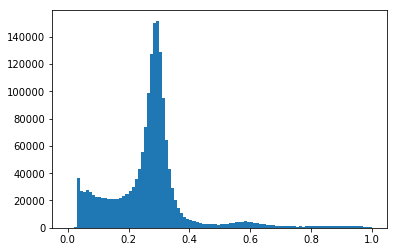

In [11]:
ici_ger=df_with_ici.filter(df_with_ici.species=="Gervais").select("ici").rdd.flatMap(lambda x: x).collect()

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist([x for x in ici_ger if x], bins=100, range=(0, 1))
plt.show()

### ICI with Cuviers

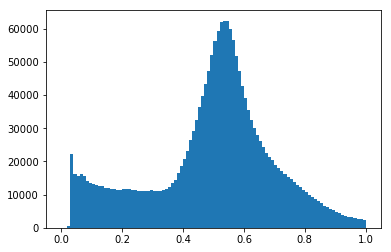

In [12]:
ici_cur=df_with_ici.filter(df_with_ici.species=="Cuviers").select("ici").rdd.flatMap(lambda x: x).collect()

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist([x for x in ici_cur if x], bins=100, range=(0, 1))
plt.show()

### ICI Mode per Bout

Calculating ICI per bout by taking mode of all the ICI's in the given bout.

In [13]:
## Trim ICI to Two Decimal Places
lookup_grouped = df_with_ici.withColumn('ici_temp', df_with_ici.ici * 100).drop('ici')
lookup_grouped = lookup_grouped.withColumn('ici_100', lookup_grouped.ici_temp.cast('bigint')).drop('ici_temp')

## Calculate Mode
lookup_grouped = lookup_grouped.groupBy(['bout_i', 'ici_100']).count()
lookup_grouped_max = lookup_grouped.groupBy('bout_i').agg({'count':'max'}).withColumnRenamed("max(count)", "max_ct")
lookup_mode = lookup_grouped_max.alias('a').join(lookup_grouped.alias('b'), (col('a.bout_i') == col('b.bout_i')) & (col('a.max_ct') == col('b.count')) , 'left')
lookup_mode = lookup_mode.groupBy('a.bout_i').agg({'ici_100':'avg'}).withColumnRenamed("avg(ici_100)", "mode_ici")
lookup_mode.cache().count()

821

### ICI Median

In [14]:
def median(values_list):
    med = np.median(values_list)
    return float(med)

udf_median = udf(median, FloatType())

lookup_grouped_median = df_with_ici.groupby(['bout_i'])
lookup_median = lookup_grouped_median.agg(udf_median(collect_list('ici')).alias('median_ici'))
lookup_median.cache()

DataFrame[bout_i: bigint, median_ici: float]

In [15]:
df_final = df_with_ici.alias('a').join(lookup_mode.alias('b'), 'bout_i')

df_final.cache().count()

4144531

## Defining Features

In [16]:
def features(row):
    array = trimmed_spectra(row)
    rmse = np.std(array)
    projections = project(array)
    ici = row.mode_ici
    peak2peak = row.peak2peak
    return np.hstack((projections, [rmse, ici, peak2peak]))

## Creating Training and Test Data

### Filtering Samples

Only taking the samples which were neither Misclassified (MS = 0) nor Falsely Detected (FD = 0)

In [17]:
Cuviers=df_final.filter(df.species==u'Cuviers')
Gervais=df_final.filter(df.species==u'Gervais')

In [18]:
cuv_bout=Cuviers.groupBy("bout_i").count()
ger_bout=Gervais.groupBy("bout_i").count()

In [19]:
mode_bout = cuv_bout.alias('c').join(ger_bout.alias('d'), (col('c.bout_i') == col('d.bout_i')),'full')
mode_bout_list=mode_bout.collect()

#### Labelling as Cuviers: 1 and Gervais: 0 for each bout. Labeled if ratio is greater than 0.5

In [21]:
label_dict={}
for i in mode_bout_list:
    bout=i[0]
    cuv_count = i[1] if i[1] else 0
    ger_count = i[3] if i[3] else 0
    ratio_cuv= 1.0 * cuv_count / (cuv_count + ger_count)
    label_dict[bout]=(1 if ratio_cuv>=0.65 else (0 if ratio_cuv <=0.35 else 2))

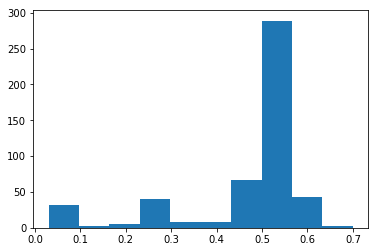

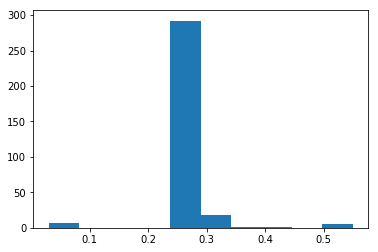

In [22]:
ici_cuv = []
ici_ger = []
for i in lookup_mode.collect():
    bout=i[0]
    if label_dict[bout] == 1:
        ici_cuv.append(1.0 * i[1] / 100)
    else:
        ici_ger.append(1.0 * i[1] / 100)  
        
plt.hist(ici_cuv, bins=10)
plt.show()

plt.hist(ici_ger, bins=10)
plt.show()

### median


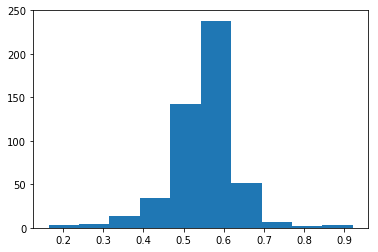

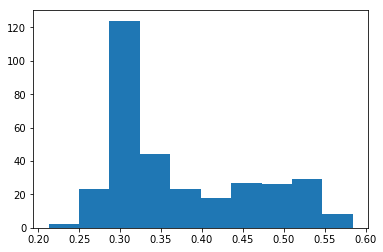

In [23]:
ici_cuv = []
ici_ger = []
for i in lookup_median.collect():
    bout=i[0]
    if label_dict[bout] == 1:
        ici_cuv.append(1.0 * i[1])
    else:
        ici_ger.append(1.0 * i[1])  
        
plt.hist(ici_cuv, bins=10)
plt.show()

plt.hist(ici_ger, bins=10)
plt.show()

## Reasigning Labels

In [24]:
def convert_to_list(dict_1):
    dictlist = []
    for key, value in dict_1.iteritems():
        temp = [key,value]
        dictlist.append(temp)
    return dictlist

In [25]:
l = convert_to_list(label_dict)

In [26]:
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType

schema = StructType([StructField("bout_i", LongType(), True), StructField("bout_label", IntegerType(), True)])
rdd1 = sc.parallelize(l)
df_new1 = sqlContext.createDataFrame(rdd1, schema)

In [27]:
df_final_rename = df_final.alias('e').join(df_new1.alias('f'), 'bout_i')


In [28]:
Cuviers=df_final_rename.filter(df_final_rename.bout_label==1)
Gervais=df_final_rename.filter(df_final_rename.bout_label==0)

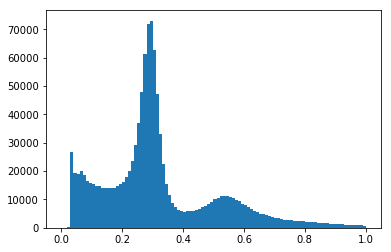

In [29]:
ici_ger=Gervais.select("ici").rdd.flatMap(lambda x: x).collect()

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist([x for x in ici_ger if x], bins=100, range=(0, 1))
plt.show()

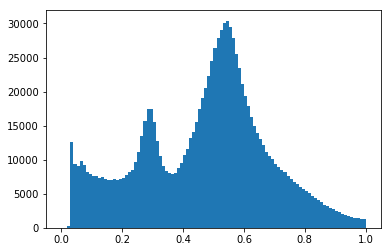

In [30]:
ici_ger=Cuviers.select("ici").rdd.flatMap(lambda x: x).collect()

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist([x for x in ici_ger if x], bins=100, range=(0, 1))
plt.show()

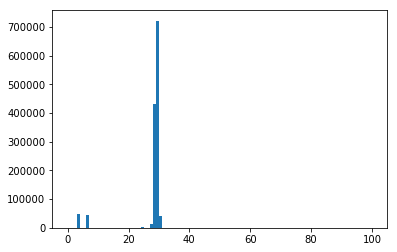

In [31]:
ici_ger=Gervais.select("mode_ici").rdd.flatMap(lambda x: x).collect()

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist([x for x in ici_ger if x], bins=100, range=(0, 100))
plt.show()

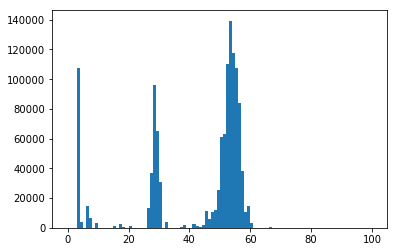

In [32]:
ici_ger=Cuviers.select("mode_ici").rdd.flatMap(lambda x: x).collect()

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist([x for x in ici_ger if x], bins=100, range=(0, 100))
plt.show()

### Feature Extraction

In [33]:
Cuvier_projections=Cuviers.rdd.map(features)
Gervais_projections=Gervais.rdd.map(features)

### Adding Labels

In [34]:
from pyspark.mllib.regression import LabeledPoint
Cuvier_samples = Cuvier_projections.map(lambda features:LabeledPoint(1, features))
Gervais_samples = Gervais_projections.map(lambda features:LabeledPoint(0, features))

Sample Check

In [35]:
Cuvier_samples.take(1)

[LabeledPoint(1.0, [-214.951054829,18.6825179931,65.4334582605,4.30022217798,1.31022351216,9.59520608467,56.0,46.326])]

In [36]:
Gervais_samples.take(1)

[LabeledPoint(0.0, [-222.609747255,-23.3386866141,108.94848139,1.08543350696,4.88404630163,9.91000418559,29.0,46.3157])]

### Creating Training and Test Data

Splitting the randomly shuffled dataset in 80/20 split for traning and testing

In [37]:
samples = Cuvier_samples.union(Gervais_samples)
[training_data, test_data] = samples.randomSplit([0.8, 0.2])
training_data.cache()
test_data.cache()

PythonRDD[207] at RDD at PythonRDD.scala:48

### Defining Score Metrics

Accuracy is being used as a scoring function

In [38]:
def score(data, model):
    predictions = model.predict(data.map(lambda x: x.features))
    labels_and_preds = data.map(lambda x: x.label).zip(predictions)
    accuracy = labels_and_preds.filter(lambda x: x[0] == x[1]).count() / float(data.count())
    return accuracy

### Logistic Regression Model

In [39]:
from pyspark.mllib.classification import LogisticRegressionWithSGD

algo = LogisticRegressionWithSGD()
model = algo.train(training_data)
print "Training Accuracy: ", score(training_data, model), ", Test Accuracy: ", score(test_data, model)

/usr/lib/spark/python/pyspark/mllib/classification.py:313: UserWarning: Deprecated in 2.0.0. Use ml.classification.LogisticRegression or LogisticRegressionWithLBFGS.
  "Deprecated in 2.0.0. Use ml.classification.LogisticRegression or "


Training Accuracy:  0.678841929423 , Test Accuracy:  0.678695035912


## SVM Model

In [40]:
from pyspark.mllib.classification import SVMWithSGD

algo = SVMWithSGD()
model = algo.train(training_data)
print "Training Accuracy: ", score(training_data, model), ", Test Accuracy: ", score(test_data, model)

Training Accuracy:  0.651530864259 , Test Accuracy:  0.651154099234


## Decision Tree

In [41]:
from pyspark.mllib.tree import DecisionTree

algo = DecisionTree()
model = algo.trainClassifier(training_data,numClasses=2,categoricalFeaturesInfo={})
print "Training Accuracy: ", score(training_data, model), ", Test Accuracy: ", score(test_data, model)

Training Accuracy:  0.895139211223 , Test Accuracy:  0.894605324104


In [42]:
model.toDebugString()

u'DecisionTreeModel classifier of depth 5 with 33 nodes\n  If (feature 6 <= 30.0)\n   If (feature 6 <= 27.0)\n    If (feature 1 <= -20.19542795232453)\n     If (feature 0 <= -106.61047144163801)\n      If (feature 6 <= 4.0)\n       Predict: 1.0\n      Else (feature 6 > 4.0)\n       Predict: 0.0\n     Else (feature 0 > -106.61047144163801)\n      If (feature 6 <= 24.0)\n       Predict: 0.0\n      Else (feature 6 > 24.0)\n       Predict: 1.0\n    Else (feature 1 > -20.19542795232453)\n     If (feature 6 <= 4.0)\n      If (feature 1 <= -6.266544095925244)\n       Predict: 1.0\n      Else (feature 1 > -6.266544095925244)\n       Predict: 1.0\n     Else (feature 6 > 4.0)\n      If (feature 6 <= 24.0)\n       Predict: 1.0\n      Else (feature 6 > 24.0)\n       Predict: 1.0\n   Else (feature 6 > 27.0)\n    If (feature 1 <= -10.57972142009637)\n     If (feature 6 <= 29.0)\n      If (feature 6 <= 28.5)\n       Predict: 0.0\n      Else (feature 6 > 28.5)\n       Predict: 0.0\n     Else (feature 

## Random Forest

In [43]:
from pyspark.mllib.tree import RandomForest

algo = RandomForest()
model = algo.trainClassifier(training_data,numClasses=2, maxDepth=3, categoricalFeaturesInfo={},numTrees=100)
print "Training Accuracy: ", score(training_data, model), ", Test Accuracy: ", score(test_data, model)

Training Accuracy:  0.889506722896 , Test Accuracy:  0.889257762413


In [45]:
from pyspark.mllib.tree import RandomForest

algo = RandomForest()
model = algo.trainClassifier(training_data,numClasses=2, categoricalFeaturesInfo={},numTrees=100)
print "Training Accuracy: ", score(training_data, model), ", Test Accuracy: ", score(test_data, model)

Training Accuracy:  0.888854911052 , Test Accuracy:  0.888724994185


## GB Trees

In [44]:
from pyspark.mllib.tree import GradientBoostedTrees

algo = GradientBoostedTrees()
model = algo.trainClassifier(training_data,categoricalFeaturesInfo={}, numIterations=100, maxDepth=3)
print "Training Accuracy: ", score(training_data, model), ", Test Accuracy: ", score(test_data, model)

Training Accuracy:  0.899980887467 , Test Accuracy:  0.899362467274


In [46]:
from pyspark.mllib.tree import GradientBoostedTrees

algo = GradientBoostedTrees()
model = algo.trainClassifier(training_data,categoricalFeaturesInfo={}, numIterations=100)
print "Training Accuracy: ", score(training_data, model), ", Test Accuracy: ", score(test_data, model)

Training Accuracy:  0.899980887467 , Test Accuracy:  0.899362467274
